# cDCGAN - MNIST

Conditional GAN
對於GAN來說，我們所輸入的維度對於生成的結果來說  
是一種隱含的語意信息，不可控的因素太多，甚至我們只能抽象的去了解輸入每個維度代表的涵義  
因此conditional GAN因此催生出來  
與基本上的GAN相同  
差別在於資料集加入了label  
這個label代表著我們所期望的條件控制  
在Generator與Discriminator都加入條件label就完成了
![](https://imgur.com/pXF8V4q.png)

## MNIST手寫數字資料

相對於普通的GAN  
另外也把label也讀進來，作為條件資料一起導入訓練  
因此conditional gan也是一種監督式學習

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

(x_train, y_train), (_,_) = mnist.load_data()
x_train = (x_train-127.5)/127.5
x_train = x_train.reshape(x_train.shape+(1,))
y_train_m = to_categorical(y_train)

Using TensorFlow backend.


定義一些訓練用的資訊

In [2]:
shape = x_train[0].shape
image_size = x_train.shape[1]
input_dim=(100,)
input_label_dim=(10,)

## Generator

利用Funtion api來定義模型
輸入兩種資訊: 1. dim=100的噪訊 2. dim=10的one_hot encoding  
最後輸出為一張28*28的圖

In [3]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, BatchNormalization, Flatten, Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate


Input_L = Input(input_dim)
Input_L_label=Input(input_label_dim)
x = concatenate([Input_L,Input_L_label])

x = Dense(64*14*14,input_dim=110,activation=LeakyReLU(alpha=0.2))(x)
x = BatchNormalization(momentum=0.5)(x)
x = Reshape((14,14,64))(x)
x = UpSampling2D()(x)
x = Conv2D(64,3,padding='same',activation=LeakyReLU(alpha=0.2))(x)
x = BatchNormalization(momentum=0.5)(x)
x = Conv2D(32,3,padding='same',activation=LeakyReLU(alpha=0.2))(x)
x = BatchNormalization(momentum=0.5)(x)
x = Conv2D(1,3,padding='same',activation='tanh')(x)

Generator = Model([Input_L,Input_L_label],x)
Generator.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12544)        1392384     concatenate_1[0][0]              
__________

## Optimizer  

Optimizer = adam  
learning rate = 0.0002  
beta = 0.5

In [4]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

## Discriminator

輸入分兩部分  
其一為圖像 dim = 28*28*1  
其二為 label，由於輸入時是onehot的形式  
把其利用全連結層在reshape成28*28*1讓其可以與圖像結合  
好處是1. 如何轉維度這部分也變成由訓練決定 2.在後面的Conv2D layer可以一併帶入  
最後輸出1 or 0 代表真假，這部分與一般的GAN無異

In [5]:
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

image = (28,28,1)
labels = (10,)
input_img = Input(image)
imput_label = Input(labels)
y = Dense(image_size * image_size)(imput_label)
y = Reshape((image_size, image_size, 1))(y)
x = concatenate([input_img, y])
x = Conv2D(32,4,padding='same',activation=LeakyReLU(alpha=0.2))(x)
x = Conv2D(64,4,padding='same',activation=LeakyReLU(alpha=0.2))(x)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

Discriminator = Model([input_img,imput_label],x)
Discriminator.summary()

Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          8624        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           dense_2[0][0]                    
__________________________________________________________________________________________________
concatenat

## GAN model

把兩者串接起來就是訓練Generator的部分的GAN

In [6]:
Discriminator.trainable = False

input_dim=(100,)
input_label_dim=(10,)
Input_L = Input(input_dim)
Input_L_label=Input(input_label_dim)

output = Discriminator([Generator([Input_L,Input_L_label]),Input_L_label])
GAN = Model([Input_L,Input_L_label],output)
GAN.summary()
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    1498625     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            92689       model_1[1][0]                    
          

## Training

訓練的時候每個epoch丟入64筆資料，共訓練20000次  
訓練的順序依序是:  
1. 創造噪點，丟入generator產生合成圖像
2. 把合成圖像標記為0，樣本圖像標記為1，丟入Discriminator訓練之
3. 產生出新的噪點圖像並標記為1，丟入整體GAN model，這是為了讓generator能夠把參數修正到能產生出1的圖像
4. 重複以上訓練

Instructions for updating:
Use tf.cast instead.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator: r_loss: 0.604714, f_loss: 0.704804], [ Generator: loss: 0.522848]
epoch: 1000, [Discriminator: r_loss: 0.647949, f_loss: 0.718678], [ Generator: loss: 0.799514]
epoch: 2000, [Discriminator: r_loss: 0.708912, f_loss: 0.720098], [ Generator: loss: 0.745901]
epoch: 3000, [Discriminator: r_loss: 0.663444, f_loss: 0.683549], [ Generator: loss: 0.764141]
epoch: 4000, [Discriminator: r_loss: 0.691318, f_loss: 0.689276], [ Generator: loss: 0.743795]
epoch: 5000, [Discriminator: r_loss: 0.659662, f_loss: 0.688011], [ Generator: loss: 0.752143]
epoch: 6000, [Discriminator: r_loss: 0.718849, f_loss: 0.674640], [ Generator: loss: 0.754580]
epoch: 7000, [Discriminator: r_loss: 0.687156, f_loss: 0.683819], [ Generator: loss: 0.739272]
epoch: 8000, [Discriminator: r_loss: 0.674450, f_loss: 0.671714], [ Generator: loss: 0.754714]
epoch: 9000, [Discriminator: r_loss: 0.704110, f_loss: 0.695279], [ Generator: loss: 0.728609]
epoch: 10000, [Discriminator: r_loss: 0.653913, f_los

C:\Users\a2720\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


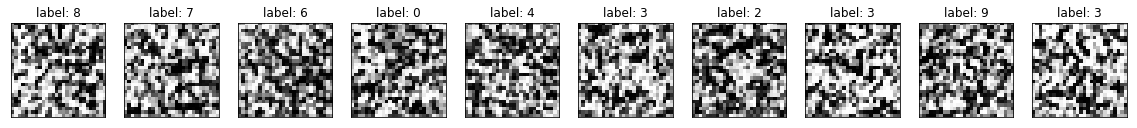

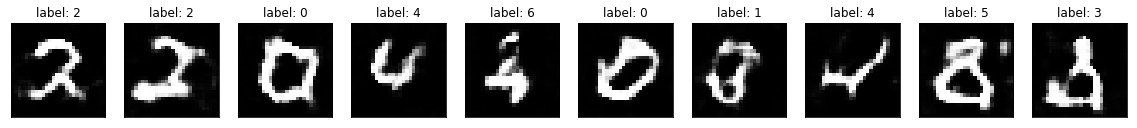

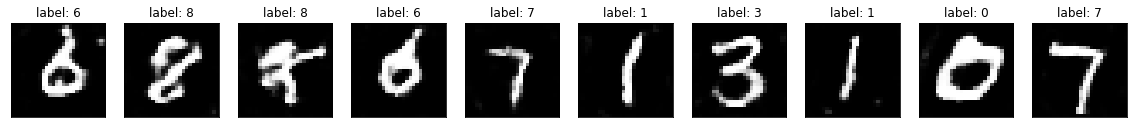

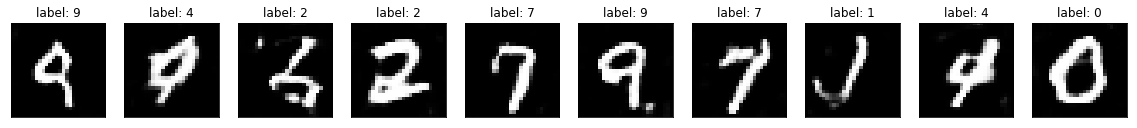

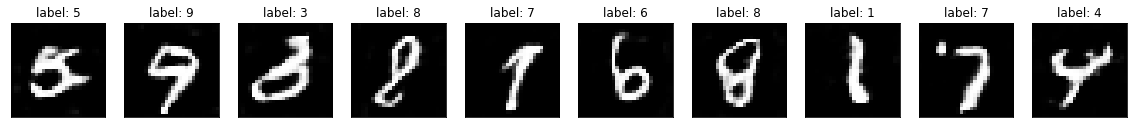

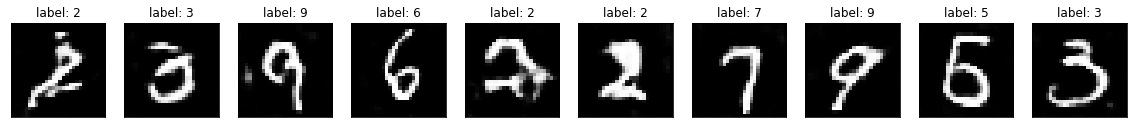

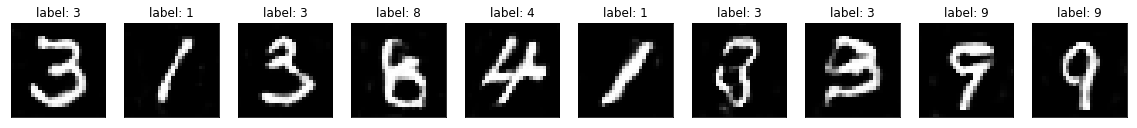

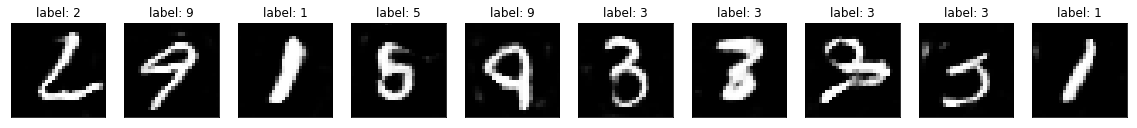

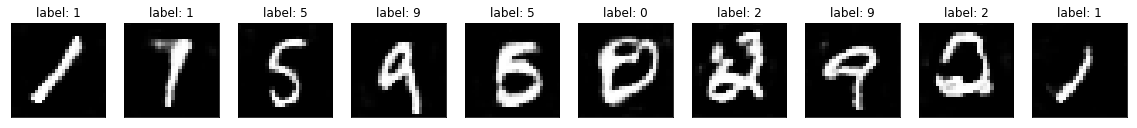

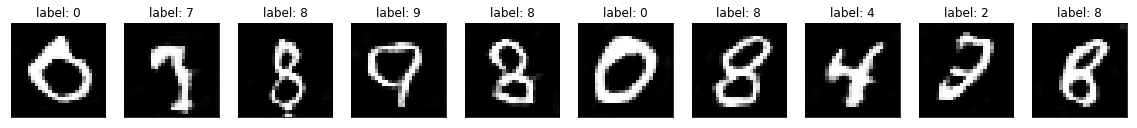

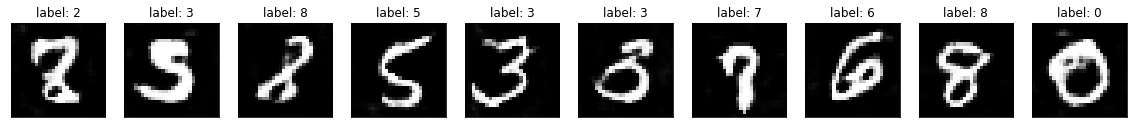

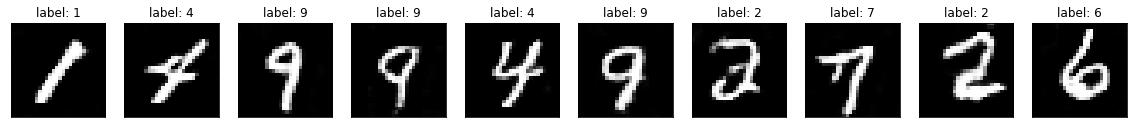

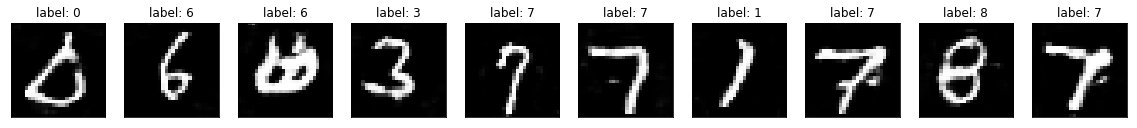

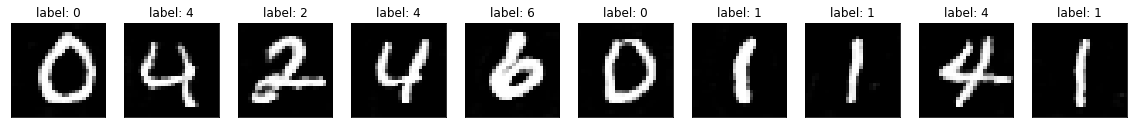

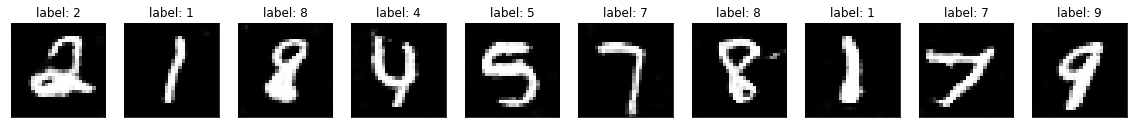

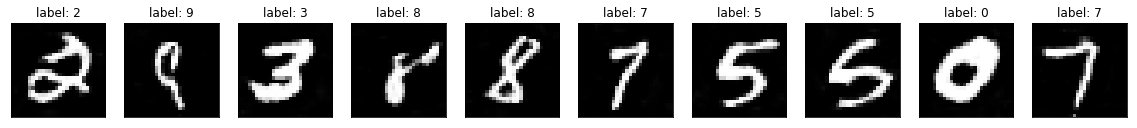

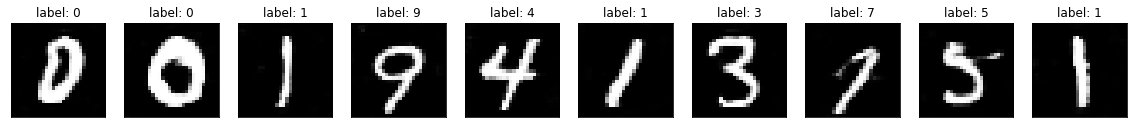

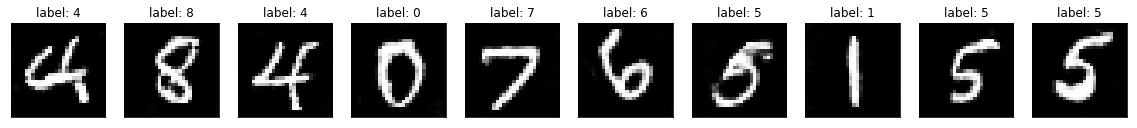

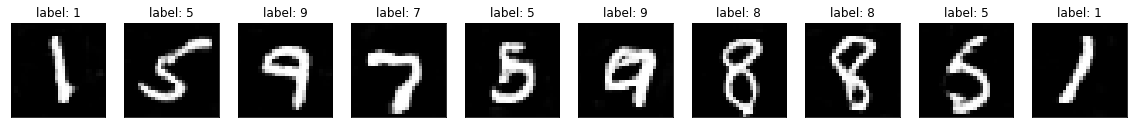

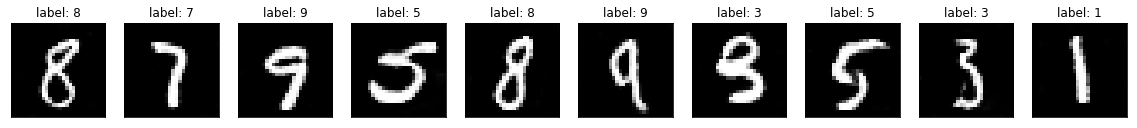

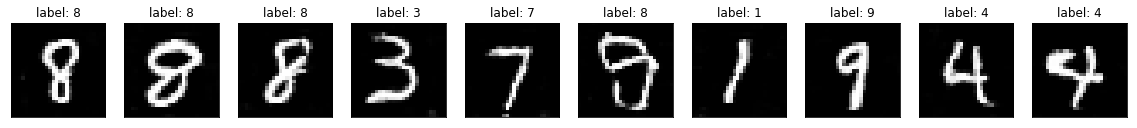

In [7]:
batch = 64
epochs = 20001
train_size = x_train.shape[0]

for times in range(epochs):
    #======================
    # train discriminater
    #======================  
    random = np.random.randint(0,train_size,int(batch/2))
    real_img = x_train[random]
    real_label = y_train_m[random]
    real_cat = np.ones(int(batch/2))
    d_loss_r = Discriminator.train_on_batch([real_img,real_label],real_cat)
    
    noise = np.random.normal(0,1,(int(batch/2),100))
    fake_label = np.eye(10)[np.arange(int(batch/2))%10]
    fake_img = Generator.predict([noise,fake_label])
    fake_cat = np.zeros(int(batch/2))
    d_loss_f = Discriminator.train_on_batch([fake_img,fake_label],fake_cat)
    
    #======================  
    #train generator
    #====================== 
    noise = np.random.normal(0,1,(batch,100))
    fake_label = np.eye(10)[np.arange(batch)%10]
    fake_cat = np.ones(batch)
    g_loss = GAN.train_on_batch([noise,fake_label],fake_cat)

    
    #option to see loss
    #print ('epoch: %d, [Discriminator: r_loss: %f, f_loss: %f], [ Generator: loss: %f]' 
    #       % (times, d_loss_r[0], d_loss_f[0], g_loss[0]))
    
    if times%1000 == 0:
        print ('epoch: %d, [Discriminator: r_loss: %f, f_loss: %f], [ Generator: loss: %f]' 
               %(times, d_loss_r[0], d_loss_f[0], g_loss[0]))
        noise = np.random.normal(0,1,(10,100))
        noise_label=np.random.randint(0,train_size,10)
        title_label = y_train[noise_label]
        noise_label_m = y_train_m[noise_label]        
        synthesis_img = Generator.predict([noise,noise_label_m])
        plt.figure(figsize=(20,2))
        for i in range(10):
            plt.subplot(1,10,i+1),plt.imshow(synthesis_img[i].reshape((28,28)),'gray')
            plt.xticks([]),plt.yticks([])
            plt.title('label: %d'%title_label[i])

每一列的圖及代表著是每經過1000次訓練後的結果  
最終經過20000次參數更新後的結果還算令人滿意

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

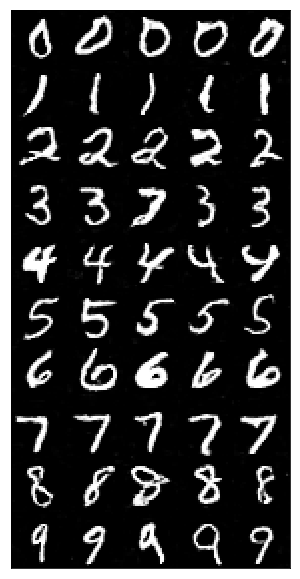

In [16]:
target = np.zeros(50)
for i in range(10):
    target[i*5:(i+1)*5] = i
target = to_categorical(target)
img = np.zeros((28*10,28*5,1))

noise = np.random.normal(0,1,(50,100))   
synthesis_img = Generator.predict([noise,target])
for i in range(50):
    r_offset = i//5
    c_offset = i%5
    img[(r_offset)*28:(r_offset+1)*28,c_offset*28:(c_offset+1)*28] = synthesis_img[i]
img = img.reshape((28*10,28*5))
plt.figure(figsize=(5,50))
plt.imshow(img,'gray')
plt.xticks([]),plt.yticks([])

## Reference

[ref1](https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py#L72)

[ref2](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter4-gan/cgan-mnist-4.3.1.py)